#import library yang diperlukan

In [1]:
# === DATA HANDLING & MANIPULATION ===
import numpy as np
import pandas as pd

# === DATA VISUALIZATION ===
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA PREPROCESSING ===
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# === MACHINE LEARNING MODELS ===
from sklearn.ensemble import RandomForestClassifier

# === MODEL EVALUATION ===
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# === SYNTHETIC DATA GENERATION ===
from sklearn.datasets import make_classification

# === WARNINGS HANDLING (optional) ===
import warnings
warnings.filterwarnings('ignore')


# Data Loading

Dataset ini dibuat untuk keperluan pelatihan dan evaluasi model klasifikasi risiko **dropout mahasiswa**. Dataset terdiri dari **500 entri mahasiswa** dengan fitur akademik dan non-akademik yang disimulasikan secara realistis.

Fitur-Fitur

1. Fitur Akademik
- `GPA_Sem1` hingga `GPA_Sem8`  
  Nilai GPA dari semester 1 sampai 8, berada dalam rentang **1.5 – 4.0**.

2. Fitur Non-Akademik
- `Attendance_Rate`  
  Persentase kehadiran kuliah mahasiswa (%).
  
- `Retaken_Courses`  
  Jumlah mata kuliah yang pernah diulang.
  
- `LMS_Activity_Score`  
  Skor aktivitas pada platform pembelajaran daring (0 – 100).
  
- `Employment_Status`  
  Status pekerjaan mahasiswa: `Employed` atau `Unemployed`.
  
- `Work_Hours`  
  Jam kerja per minggu bagi mahasiswa yang bekerja (0 – 40 jam).
  
- `Socioeconomic_Status`  
  Status sosial ekonomi: `Low`, `Middle`, atau `High`.

3. Lainnya
- `Student_ID`  
  ID unik setiap mahasiswa, dalam format `MHS001`, `MHS002`, ..., `MHS500`.

- `Dropout`  
  Label target klasifikasi:  
  - `0` = Tidak dropout  
  - `1` = Dropout  
  Distribusi data seimbang (50:50).




In [2]:
# Buat dataset klasifikasi seimbang (balanced)
# Ubah n_samples menjadi 500
X, y = make_classification(
    n_samples=500,
    n_features=8,  # 8 fitur utama seperti GPA sem 1-8
    n_informative=6,
    n_redundant=2,
    n_clusters_per_class=1,
    weights=[0.5, 0.5],
    flip_y=0.02,
    random_state=42
)

# Buat DataFrame dengan nama kolom GPA sem 1 - 8
gpa_columns = [f'GPA_Sem{i+1}' for i in range(8)]
df_gpa = pd.DataFrame(X, columns=gpa_columns)

# Transformasi nilai GPA ke rentang 1.5 - 4.0 (nilai realistis)
df_gpa = df_gpa.apply(lambda col: 1.5 + (col - col.min()) / (col.max() - col.min()) * (4.0 - 1.5))

# Tambahkan fitur lain yang distribusinya bagus
np.random.seed(42)
# Gunakan df_gpa.shape[0] untuk mendapatkan jumlah baris yang sesuai (sekarang 500)
df_gpa['Attendance_Rate'] = np.round(np.random.normal(85, 10, df_gpa.shape[0]).clip(50, 100), 2)
df_gpa['Retaken_Courses'] = np.random.poisson(1.5, df_gpa.shape[0]).clip(0, 5)
df_gpa['LMS_Activity_Score'] = np.round(np.random.normal(70, 20, df_gpa.shape[0]).clip(0, 100), 2)
df_gpa['Employment_Status'] = np.random.choice(['Employed', 'Unemployed'], df_gpa.shape[0], p=[0.4, 0.6])
df_gpa['Work_Hours'] = np.random.normal(15, 10, df_gpa.shape[0]).clip(0, 40).astype(int)
df_gpa['Socioeconomic_Status'] = np.random.choice(['Low', 'Middle', 'High'], df_gpa.shape[0], p=[0.3, 0.5, 0.2])
# Variabel target 'y' sekarang juga memiliki panjang 500
df_gpa['Dropout'] = y
df_gpa.insert(0, 'Student_ID', [f'MHS{i+1:03d}' for i in range(df_gpa.shape[0])])

df_gpa.head()

,Student_ID,GPA_Sem1,GPA_Sem2,GPA_Sem3,GPA_Sem4,GPA_Sem5,GPA_Sem6,GPA_Sem7,GPA_Sem8,Attendance_Rate,Retaken_Courses,LMS_Activity_Score,Employment_Status,Work_Hours,Socioeconomic_Status,Dropout
0,MHS001,3.022455,2.806862,3.182229,2.345541,2.849578,3.008856,2.489718,2.997361,89.97,2,95.76,Employed,10,Middle,1
1,MHS002,3.140474,3.519268,2.417743,2.479992,2.454279,2.091563,3.051875,2.196045,83.62,2,61.54,Unemployed,13,Middle,0
2,MHS003,3.415879,3.080649,2.239178,2.840006,2.509998,2.414129,2.986644,2.239343,91.48,0,75.21,Employed,20,Low,0
3,MHS004,2.632963,2.531376,2.778220,2.600768,2.500836,2.820631,2.208334,3.119932,100.00,0,41.99,Employed,13,Middle,0
4,MHS005,3.070948,3.090423,1.967964,2.705093,2.640558,2.207487,2.856562,2.435998,82.66,1,84.40,Unemployed,28,Middle,0


# Exploratory Data Analysis - Deskripsi Variabel

In [3]:
df_gpa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Student_ID            500 non-null    object 
 1   GPA_Sem1              500 non-null    float64
 2   GPA_Sem2              500 non-null    float64
 3   GPA_Sem3              500 non-null    float64
 4   GPA_Sem4              500 non-null    float64
 5   GPA_Sem5              500 non-null    float64
 6   GPA_Sem6              500 non-null    float64
 7   GPA_Sem7              500 non-null    float64
 8   GPA_Sem8              500 non-null    float64
 9   Attendance_Rate       500 non-null    float64
 10  Retaken_Courses       500 non-null    int64  
 11  LMS_Activity_Score    500 non-null    float64
 12  Employment_Status     500 non-null    object 
 13  Work_Hours            500 non-null    int64  
 14  Socioeconomic_Status  500 non-null    object 
 15  Dropout               5

Insight :
- **Jumlah data**: 500 baris (mahasiswa)
- **Jumlah kolom**: 16
  - **Fitur numerik**: 13 kolom (`float64` dan `int64`)
  - **Fitur kategorikal**: 3 kolom (`object`)
- **Penggunaan memori**: ~62.6 KB

✅ Kualitas Data
- **Semua kolom memiliki 500 entri** → tidak ada nilai kosong (missing).
- **Tipe data sesuai**:
  - GPA dan skor aktivitas: `float64`
  - Jumlah mata kuliah dan jam kerja: `int64`
  - ID mahasiswa, status kerja, dan status sosial ekonomi: `object`



In [4]:
df_gpa.describe()

,GPA_Sem1,GPA_Sem2,GPA_Sem3,GPA_Sem4,GPA_Sem5,GPA_Sem6,GPA_Sem7,GPA_Sem8,Attendance_Rate,Retaken_Courses,LMS_Activity_Score,Work_Hours,Dropout
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.904173,2.736927,2.595929,2.541262,2.715197,2.544943,2.600542,2.875649,84.743460,1.462000,69.426180,14.856000,0.506000
std,0.420961,0.427976,0.464548,0.364109,0.397105,0.454325,0.403906,0.374856,9.127939,1.208087,19.096015,9.117759,0.500465
min,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000,52.590000,0.000000,12.570000,0.000000,0.000000
25%,2.659207,2.461289,2.241600,2.306424,2.447127,2.229985,2.313961,2.650213,77.995000,1.000000,56.240000,8.000000,0.000000
50%,2.923595,2.740256,2.538809,2.546713,2.713461,2.460599,2.598429,2.935096,85.130000,1.000000,70.130000,15.000000,1.000000
75%,3.177710,3.018929,2.903720,2.773725,2.986490,2.813794,2.869330,3.149608,91.367500,2.000000,84.417500,21.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,100.000000,5.000000,100.000000,40.000000,1.000000


##Menangani outliers

In [5]:
# Cek dan hitung outlier untuk setiap kolom numerik
numerical_cols = df_gpa.select_dtypes(include=np.number).columns

outliers_count = {}

for col in numerical_cols:
    # Hitung Q1, Q3, dan IQR
    Q1 = df_gpa[col].quantile(0.25)
    Q3 = df_gpa[col].quantile(0.75)
    IQR = Q3 - Q1

    # Tentukan batas bawah dan atas outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifikasi outlier
    col_outliers = df_gpa[(df_gpa[col] < lower_bound) | (df_gpa[col] > upper_bound)]

    # Hitung jumlah outlier
    outliers_count[col] = col_outliers.shape[0]

# Tampilkan jumlah outlier per kolom
print("Jumlah Outlier per Variabel Numerik:")
for col, count in outliers_count.items():
    print(f"- {col}: {count}")

Jumlah Outlier per Variabel Numerik:
- GPA_Sem1: 10
- GPA_Sem2: 5
- GPA_Sem3: 1
- GPA_Sem4: 8
- GPA_Sem5: 8
- GPA_Sem6: 7
- GPA_Sem7: 5
- GPA_Sem8: 7
- Attendance_Rate: 1
- Retaken_Courses: 31
- LMS_Activity_Score: 1
- Work_Hours: 0
- Dropout: 0


Insight :    
Sebagian besar variabel numerik memiliki sedikit outlier, namun Retaken_Courses menonjol dengan jumlah outlier tertinggi (31 kasus), yang menunjukkan variasi ekstrem dalam jumlah mata kuliah yang diulang oleh mahasiswa.

In [6]:
# Buat salinan DataFrame agar data asli tidak berubah
df_gpa_cleaned = df_gpa.copy()

# Menangani outlier dengan Capping (menggunakan batas IQR)
for col in numerical_cols:
    Q1 = df_gpa_cleaned[col].quantile(0.25)
    Q3 = df_gpa_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Terapkan capping
    df_gpa_cleaned[col] = df_gpa_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

print("\nDataFrame setelah menangani outlier dengan Capping:")
# Tampilkan deskripsi statistik untuk melihat efek capping
print(df_gpa_cleaned.describe())

# Anda juga bisa memeriksa kembali jumlah outlier setelah capping
print("\nJumlah Outlier per Variabel Numerik setelah Capping:")
outliers_count_cleaned = {}
for col in numerical_cols:
     Q1 = df_gpa_cleaned[col].quantile(0.25)
     Q3 = df_gpa_cleaned[col].quantile(0.75)
     IQR = Q3 - Q1
     lower_bound = Q1 - 1.5 * IQR
     upper_bound = Q3 + 1.5 * IQR
     col_outliers = df_gpa_cleaned[(df_gpa_cleaned[col] < lower_bound) | (df_gpa_cleaned[col] > upper_bound)]
     outliers_count_cleaned[col] = col_outliers.shape[0]

for col, count in outliers_count_cleaned.items():
     print(f"- {col}: {count}")


DataFrame setelah menangani outlier dengan Capping:
         GPA_Sem1    GPA_Sem2    GPA_Sem3    GPA_Sem4    GPA_Sem5    GPA_Sem6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.907327    2.737065    2.595723    2.539479    2.715748    2.543099   
std      0.411213    0.425563    0.463946    0.357423    0.392607    0.449144   
min      1.881453    1.624830    1.500000    1.605474    1.638084    1.500000   
25%      2.659207    2.461289    2.241600    2.306424    2.447127    2.229985   
50%      2.923595    2.740256    2.538809    2.546713    2.713461    2.460599   
75%      3.177710    3.018929    2.903720    2.773725    2.986490    2.813794   
max      3.955464    3.855388    3.896900    3.474675    3.795534    3.689508   

         GPA_Sem7    GPA_Sem8  Attendance_Rate  Retaken_Courses  \
count  500.000000  500.000000       500.000000       500.000000   
mean     2.599243    2.877797        84.754153         1.413000   
std      0.40002

Insight :

Setelah diterapkan teknik capping, seluruh outlier berhasil diatasi, menghasilkan distribusi nilai yang lebih stabil tanpa mengubah karakteristik utama data.


##Mengecek distribusi data

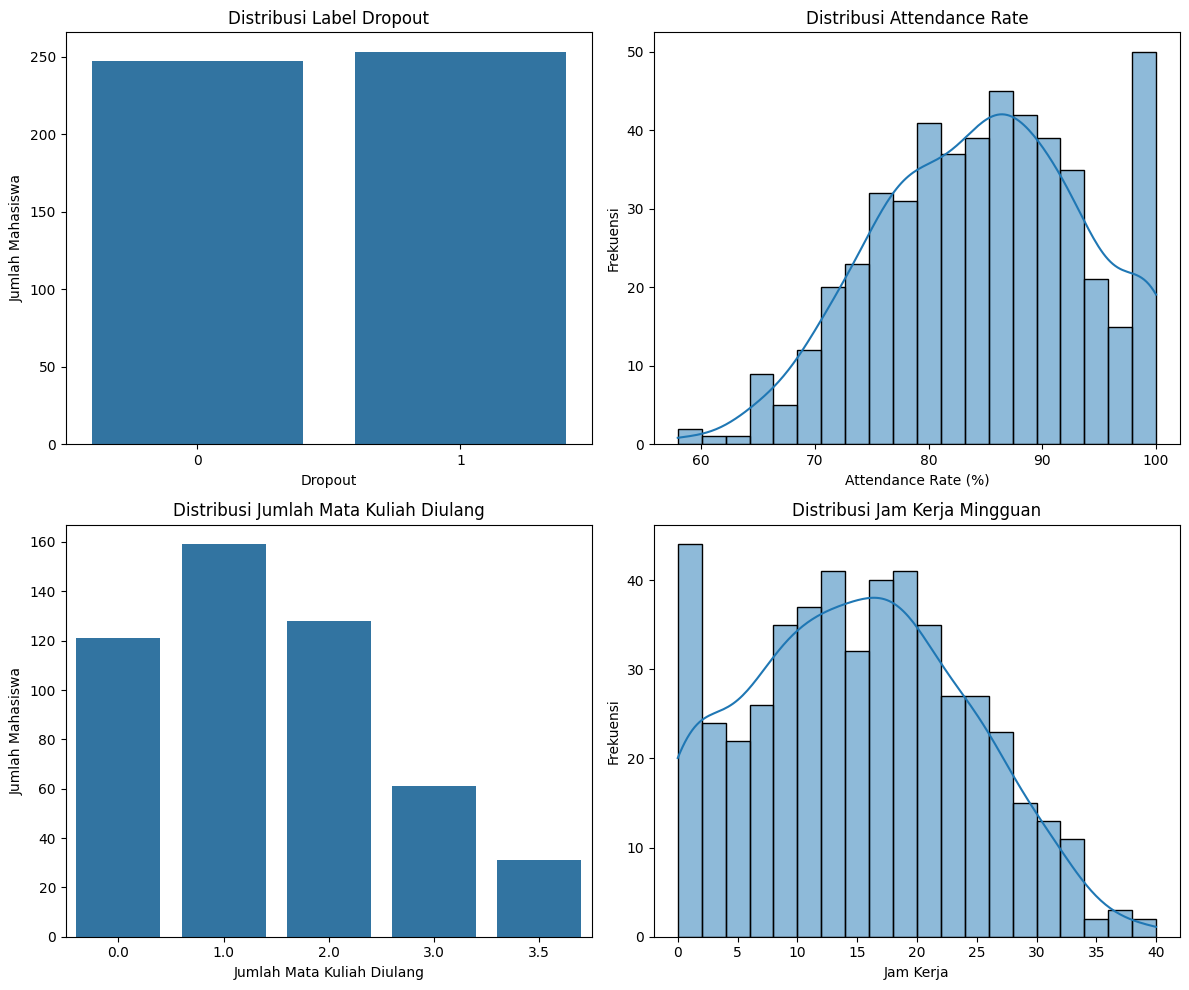

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # Buat grid 2x2 untuk plot

# Plot 1: Distribusi Label Dropout
sns.countplot(x='Dropout', data=df_gpa_cleaned, ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Label Dropout')
axes[0, 0].set_xlabel('Dropout')
axes[0, 0].set_ylabel('Jumlah Mahasiswa')

# Plot 2: Distribusi Attendance Rate
sns.histplot(df_gpa_cleaned['Attendance_Rate'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribusi Attendance Rate')
axes[0, 1].set_xlabel('Attendance Rate (%)')
axes[0, 1].set_ylabel('Frekuensi')

# Plot 3: Distribusi Retaken Courses
sns.countplot(x='Retaken_Courses', data=df_gpa_cleaned, ax=axes[1, 0])
axes[1, 0].set_title('Distribusi Jumlah Mata Kuliah Diulang')
axes[1, 0].set_xlabel('Jumlah Mata Kuliah Diulang')
axes[1, 0].set_ylabel('Jumlah Mahasiswa')

# Plot 4: Distribusi Work Hours
sns.histplot(df_gpa_cleaned['Work_Hours'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribusi Jam Kerja Mingguan')
axes[1, 1].set_xlabel('Jam Kerja')
axes[1, 1].set_ylabel('Frekuensi')

plt.tight_layout() # Mengatur layout agar tidak tumpang tindih
plt.show()

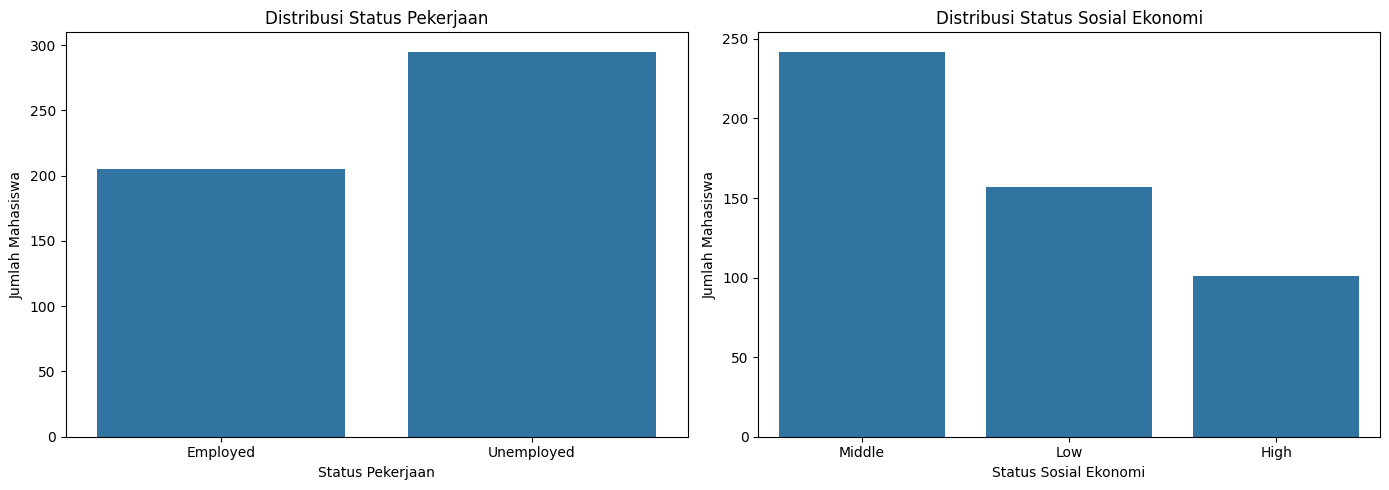

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # Buat grid 1x2 untuk plot

# Plot 1: Distribusi Employment Status
sns.countplot(x='Employment_Status', data=df_gpa_cleaned, ax=axes[0])
axes[0].set_title('Distribusi Status Pekerjaan')
axes[0].set_xlabel('Status Pekerjaan')
axes[0].set_ylabel('Jumlah Mahasiswa')

# Plot 2: Distribusi Socioeconomic Status
sns.countplot(x='Socioeconomic_Status', data=df_gpa_cleaned, ax=axes[1])
axes[1].set_title('Distribusi Status Sosial Ekonomi')
axes[1].set_xlabel('Status Sosial Ekonomi')
axes[1].set_ylabel('Jumlah Mahasiswa')

plt.tight_layout() # Mengatur layout agar tidak tumpang tindih
plt.show()

Insight : Distribusi setiap variabel cukup bagus setelah outliersnya ditangani

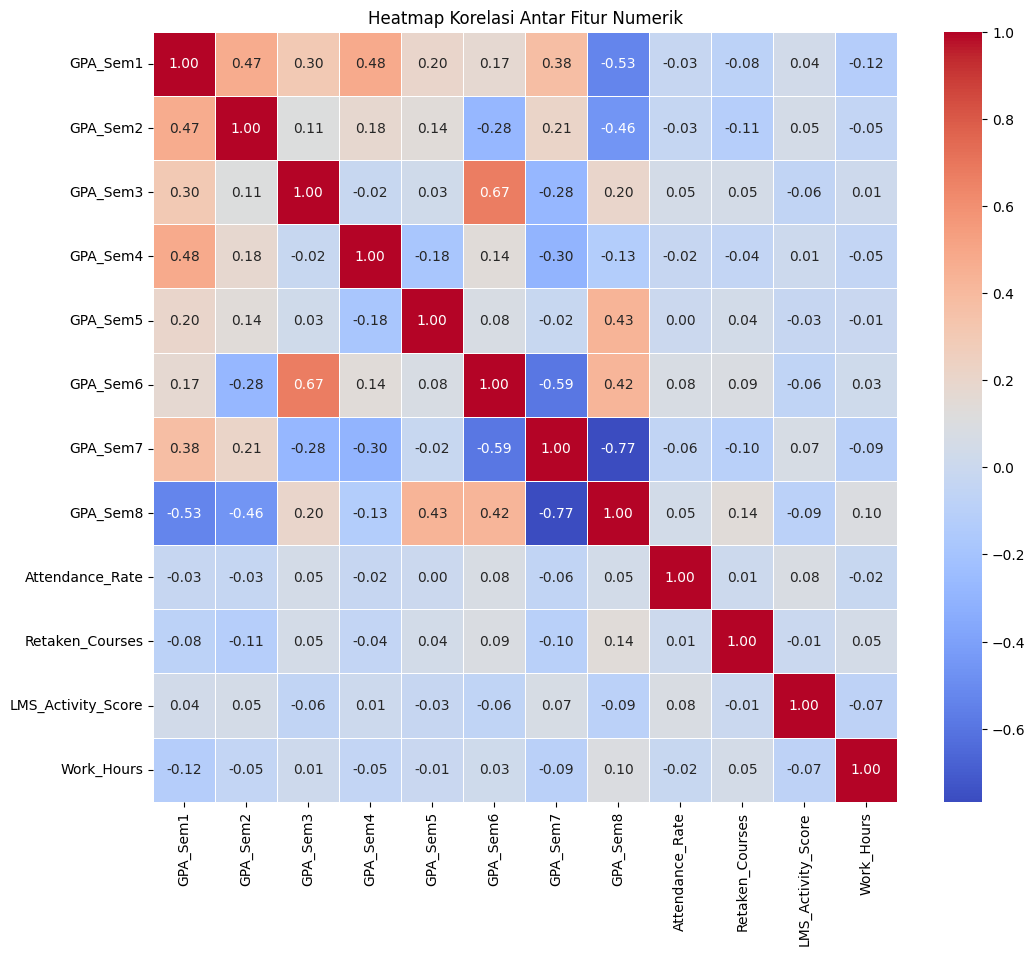

In [9]:
# Pilih kolom numerik (kecuali Student_ID dan Dropout)
numerical_cols_for_corr = df_gpa_cleaned.select_dtypes(include=np.number).columns.tolist()
# Hapus 'Dropout' karena ini adalah target, dan Student_ID karena bukan fitur numerik
numerical_cols_for_corr.remove('Dropout')
if 'Student_ID' in numerical_cols_for_corr:
    numerical_cols_for_corr.remove('Student_ID')

# Hitung matriks korelasi
correlation_matrix = df_gpa_cleaned[numerical_cols_for_corr].corr()

# Buat heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.show()

#Data preprosessing

##Encoding data kategorikal

In [10]:
# Identifikasi kolom kategorikal
categorical_cols = ['Employment_Status', 'Socioeconomic_Status']

# Lakukan One-Hot Encoding
df_gpa_encoded = pd.get_dummies(df_gpa_cleaned, columns=categorical_cols, drop_first=True)

# Tampilkan beberapa baris pertama dari DataFrame yang sudah di-encoded
df_gpa_encoded.head()

,Student_ID,GPA_Sem1,GPA_Sem2,GPA_Sem3,GPA_Sem4,GPA_Sem5,GPA_Sem6,GPA_Sem7,GPA_Sem8,Attendance_Rate,Retaken_Courses,LMS_Activity_Score,Work_Hours,Dropout,Employment_Status_Unemployed,Socioeconomic_Status_Low,Socioeconomic_Status_Middle
0,MHS001,3.022455,2.806862,3.182229,2.345541,2.849578,3.008856,2.489718,2.997361,89.97,2.0,95.76,10,1,False,False,True
1,MHS002,3.140474,3.519268,2.417743,2.479992,2.454279,2.091563,3.051875,2.196045,83.62,2.0,61.54,13,0,True,False,True
2,MHS003,3.415879,3.080649,2.239178,2.840006,2.509998,2.414129,2.986644,2.239343,91.48,0.0,75.21,20,0,False,True,False
3,MHS004,2.632963,2.531376,2.778220,2.600768,2.500836,2.820631,2.208334,3.119932,100.00,0.0,41.99,13,0,False,False,True
4,MHS005,3.070948,3.090423,1.967964,2.705093,2.640558,2.207487,2.856562,2.435998,82.66,1.0,84.40,28,0,True,False,True


Insight :

Kolom kategorikal berhasil dikonversi menjadi representasi numerik melalui one-hot encoding, menghasilkan fitur biner baru seperti Employment_Status_Unemployed dan Socioeconomic_Status_Low/Middle yang siap digunakan dalam model machine learning.

#Feature engineering menggunakan PCA

lasan Dilakukannya PCA pada Fitur GPA (IPK)
 --------------------------------------------
 Dataset memiliki 8 variabel terpisah untuk GPA dari semester 1 hingga 8 (GPA_Sem1 s.d. GPA_Sem8).
 Penggunaan semua variabel ini secara langsung dalam model dapat menyebabkan:
   1. Redundansi informasi (karena GPA antar semester cenderung berkorelasi tinggi).
   2. Dimensi fitur yang tinggi, yang dapat meningkatkan kompleksitas model dan risiko overfitting.


 Oleh karena itu, dilakukan reduksi dimensi menggunakan PCA (Principal Component Analysis)
 khusus untuk fitur GPA. PCA bertujuan untuk:
   - Menyatukan informasi utama dari 8 semester GPA menjadi beberapa komponen utama.
   - Mengurangi jumlah fitur sambil tetap mempertahankan sebagian besar variansi data.
   - Membantu meningkatkan efisiensi pemodelan tanpa kehilangan informasi penting.


 Komponen hasil PCA nantinya digunakan sebagai fitur baru yang merepresentasikan
 tren dan variasi nilai akademik mahasiswa secara lebih ringkas dan informatif.


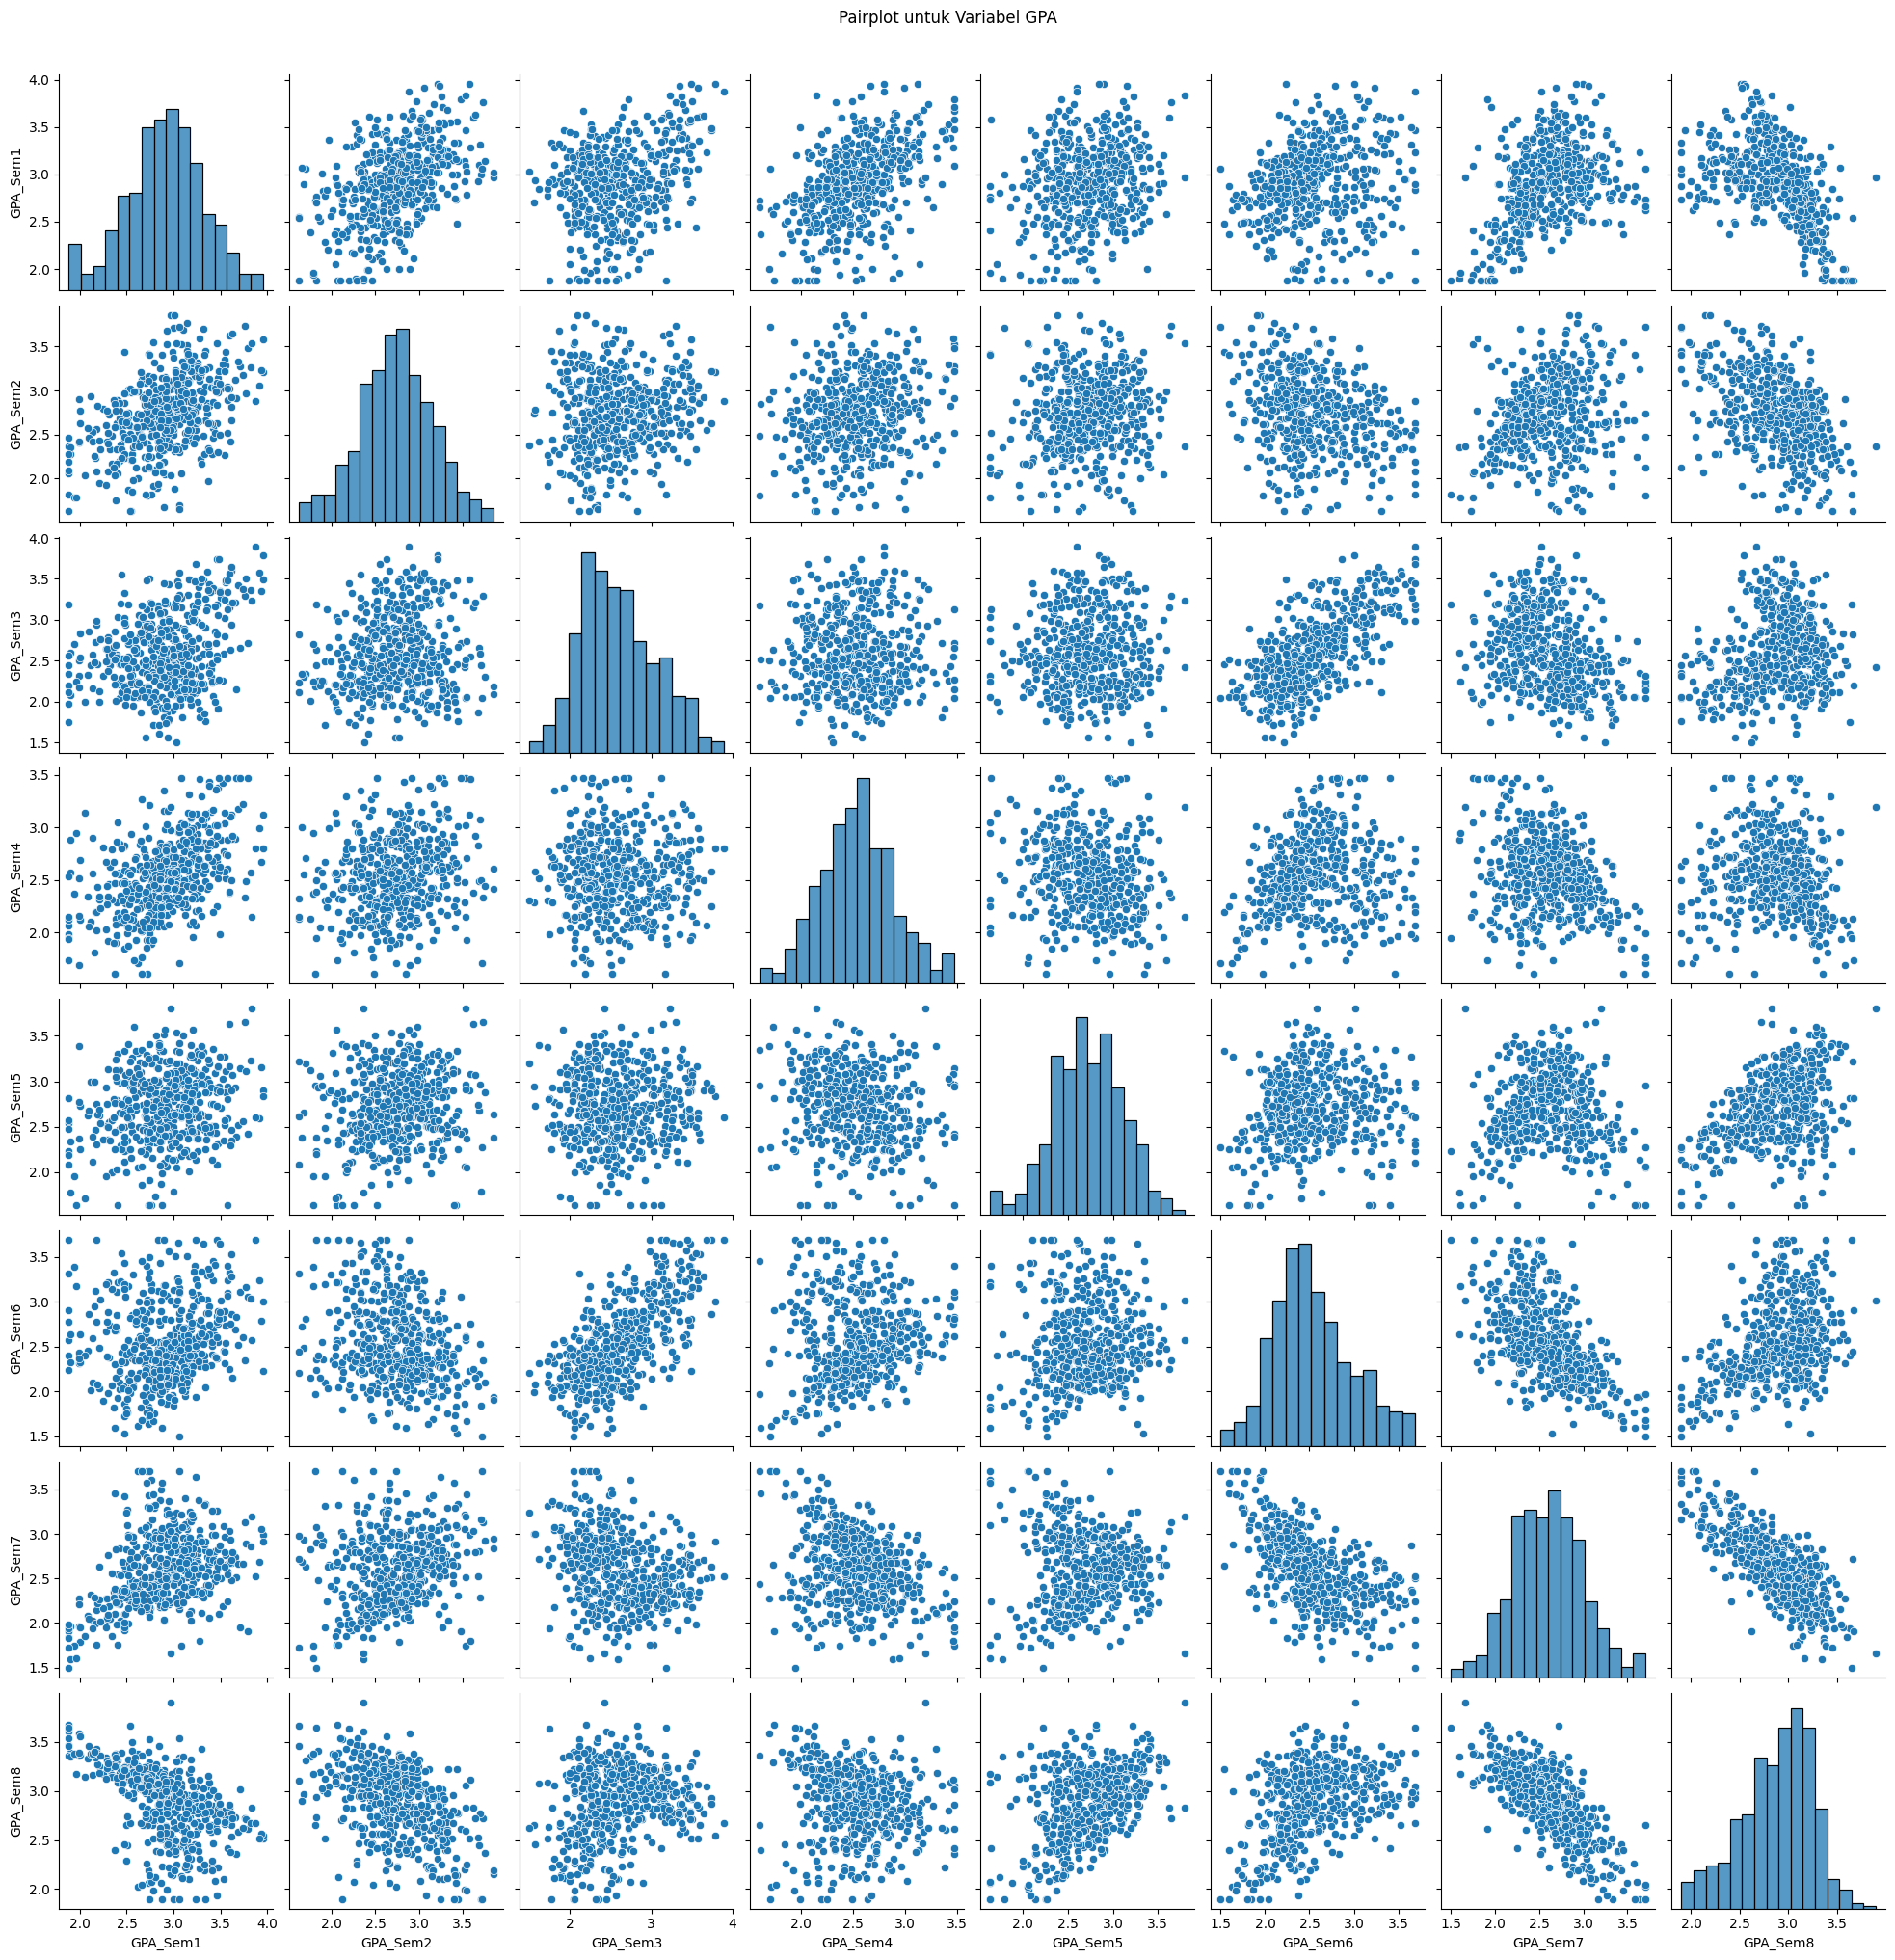

In [11]:
# Pilih kolom GPA
gpa_columns = [f'GPA_Sem{i+1}' for i in range(8)]

# Buat pairplot untuk kolom GPA
sns.pairplot(df_gpa_encoded[gpa_columns])
plt.suptitle('Pairplot untuk Variabel GPA', y=1.02)
plt.show()

Insight :

Berdasarkan visualisasi pairplot GPA semester 1 hingga 8:
- Terdapat korelasi positif yang kuat antar semester, menandakan pola performa akademik mahasiswa relatif konsisten dari waktu ke waktu.
- Hal ini menunjukkan bahwa GPA antar semester memiliki informasi yang tumpang tindih, sehingga dapat direduksi dengan teknik seperti PCA.
- Distribusi GPA bersifat normal moderat, tidak banyak outlier ekstrem, sehingga cocok digunakan dalam model prediktif.


Explained variance ratio per principal component:
[0.34568427 0.2525365 ]

Total explained variance ratio by 2 components: 0.5982


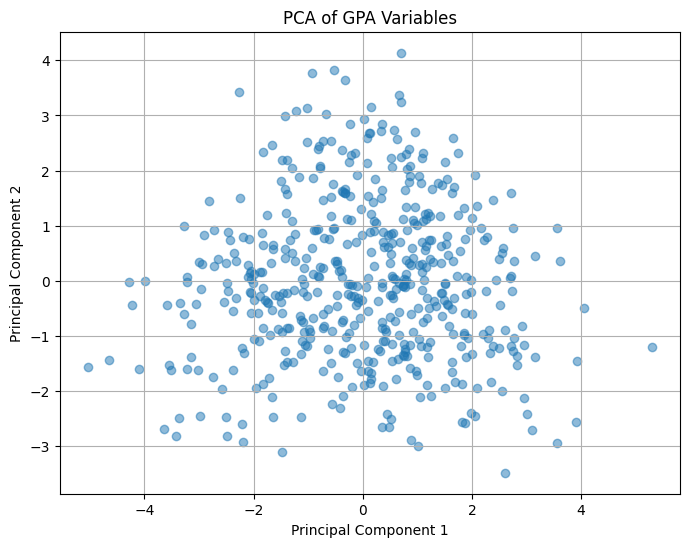

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Pilih kolom GPA
gpa_columns = [f'GPA_Sem{i+1}' for i in range(8)]
df_gpa_subset = df_gpa_encoded[gpa_columns]

# Scaling data
scaler = StandardScaler()
gpa_scaled = scaler.fit_transform(df_gpa_subset)

# Inisialisasi PCA (misalnya, dengan 2 komponen)
pca = PCA(n_components=2)

# Terapkan PCA
gpa_pca = pca.fit_transform(gpa_scaled)

# Buat DataFrame dari hasil PCA (opsional, untuk kemudahan visualisasi)
df_gpa_pca = pd.DataFrame(data = gpa_pca, columns = ['principal component 1', 'principal component 2'])

# Tampilkan variance ratio yang dijelaskan oleh setiap komponen
print("Explained variance ratio per principal component:")
print(pca.explained_variance_ratio_)

# Tampilkan total variance ratio yang dijelaskan
print(f"\nTotal explained variance ratio by {pca.n_components} components: {sum(pca.explained_variance_ratio_):.4f}")

# Visualisasikan hasil PCA (jika n_components <= 2)
if pca.n_components <= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_gpa_pca['principal component 1'], df_gpa_pca['principal component 2'], alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of GPA Variables')
    plt.grid(True)
    plt.show()

Insight :
- Dua komponen utama berhasil menjelaskan sekitar 59.8% variansi dari 8 variabel GPA.

- Sebaran data menyebar merata, tidak menunjukkan klaster jelas, artinya distribusi GPA mahasiswa cenderung kontinu dan tidak membentuk kelompok ekstrem.

- Reduksi dimensi ini efisien untuk menyederhanakan model prediksi tanpa kehilangan banyak informasi. Sangat berguna untuk mengurangi kompleksitas model seperti Random Forest.

In [13]:
df_gpa_encoded.head()

,Student_ID,GPA_Sem1,GPA_Sem2,GPA_Sem3,GPA_Sem4,GPA_Sem5,GPA_Sem6,GPA_Sem7,GPA_Sem8,Attendance_Rate,Retaken_Courses,LMS_Activity_Score,Work_Hours,Dropout,Employment_Status_Unemployed,Socioeconomic_Status_Low,Socioeconomic_Status_Middle
0,MHS001,3.022455,2.806862,3.182229,2.345541,2.849578,3.008856,2.489718,2.997361,89.97,2.0,95.76,10,1,False,False,True
1,MHS002,3.140474,3.519268,2.417743,2.479992,2.454279,2.091563,3.051875,2.196045,83.62,2.0,61.54,13,0,True,False,True
2,MHS003,3.415879,3.080649,2.239178,2.840006,2.509998,2.414129,2.986644,2.239343,91.48,0.0,75.21,20,0,False,True,False
3,MHS004,2.632963,2.531376,2.778220,2.600768,2.500836,2.820631,2.208334,3.119932,100.00,0.0,41.99,13,0,False,False,True
4,MHS005,3.070948,3.090423,1.967964,2.705093,2.640558,2.207487,2.856562,2.435998,82.66,1.0,84.40,28,0,True,False,True


Gabungkan DataFrame hasil PCA (df_gpa_pca) dengan DataFrame yang sudah di-encoded (df_gpa_encoded)

In [14]:
# Pastikan indeksnya selaras
df_gpa_final = pd.concat([df_gpa_encoded.drop(gpa_columns, axis=1), df_gpa_pca], axis=1)

df_gpa_final.head()

,Student_ID,Attendance_Rate,Retaken_Courses,LMS_Activity_Score,Work_Hours,Dropout,Employment_Status_Unemployed,Socioeconomic_Status_Low,Socioeconomic_Status_Middle,principal component 1,principal component 2
0,MHS001,89.97,2.0,95.76,10,1,False,False,True,0.987004,1.016176
1,MHS002,83.62,2.0,61.54,13,0,True,False,True,-2.947608,0.296931
2,MHS003,91.48,0.0,75.21,20,0,False,True,False,-2.462938,0.881410
3,MHS004,100.00,0.0,41.99,13,0,False,False,True,1.498749,-0.047316
4,MHS005,82.66,1.0,84.40,28,0,True,False,True,-2.055775,-0.199358


## Train Test Split

- X: Fitur tanpa Student_ID dan Dropout.

- y: Label dropout (0 atau 1).

- train_test_split: Membagi data jadi 70% latih, 30% uji, dengan proporsi label seimbang (stratify=y).


In [15]:
# Identifikasi fitur (X) dan target (y)
X = df_gpa_final.drop(['Student_ID', 'Dropout'], axis=1)
y = df_gpa_final['Dropout']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Tampilkan ukuran set hasil split
print("Ukuran data setelah splitting:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Ukuran data setelah splitting:
X_train shape: (350, 9)
X_test shape: (150, 9)
y_train shape: (350,)
y_test shape: (150,)


## Standarisasi

🎯 Tujuan
Melakukan **standarisasi** pada fitur numerik agar memiliki **mean sekitar 0** dan **standar deviasi sekitar 1**, yang penting untuk algoritma pembelajaran mesin berbasis skala, seperti Random Forest.


🔍 Fitur yang Distandarisasi
- `Attendance_Rate`
- `Retaken_Courses`
- `LMS_Activity_Score`
- `Work_Hours`
- `principal component 1`
- `principal component 2`

⚙️ Proses
1. Menggunakan `StandardScaler` dari Scikit-learn.
2. `fit_transform()` diterapkan hanya pada `X_train` untuk menghindari kebocoran data (data leakage).
3. `transform()` digunakan pada `X_test` menggunakan parameter hasil dari `X_train`.

In [16]:
# Impor StandardScaler jika belum dilakukan
from sklearn.preprocessing import StandardScaler
numerical_cols_to_scale = ['Attendance_Rate', 'Retaken_Courses', 'LMS_Activity_Score', 'Work_Hours', 'principal component 1', 'principal component 2']

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler HANYA pada data pelatihan dan transform X_train
X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])

# Transform X_test menggunakan scaler yang sudah difit dari data pelatihan
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])

# Tampilkan deskripsi statistik X_train setelah standarisasi untuk verifikasi (mean sekitar 0, std sekitar 1)
print("Deskripsi Statistik X_train setelah Standarisasi:")
print(X_train.describe())

# Tampilkan deskripsi statistik X_test setelah standarisasi
print("\nDeskripsi Statistik X_test setelah Transformasi:")
print(X_test.describe())

Deskripsi Statistik X_train setelah Standarisasi:
       Attendance_Rate  Retaken_Courses  LMS_Activity_Score    Work_Hours  \
count     3.500000e+02     3.500000e+02        3.500000e+02  3.500000e+02   
mean     -1.509903e-16    -4.060244e-17        5.075305e-18  6.090366e-17   
std       1.001432e+00     1.001432e+00        1.001432e+00  1.001432e+00   
min      -2.916715e+00    -1.306229e+00       -2.911000e+00 -1.606092e+00   
25%      -7.227565e-01    -3.955116e-01       -6.962058e-01 -7.350756e-01   
50%       2.471640e-02    -3.955116e-01        6.792435e-02  2.706372e-02   
75%       6.983718e-01     5.152059e-01        8.098276e-01  6.803260e-01   
max       1.726464e+00     1.881282e+00        1.585400e+00  2.748990e+00   

       principal component 1  principal component 2  
count           3.500000e+02           3.500000e+02  
mean            5.075305e-18          -2.030122e-17  
std             1.001432e+00           1.001432e+00  
min            -2.922161e+00          -2

Insight :

- Fitur yang telah distandarisasi siap digunakan untuk pelatihan dan pengujian model.
- Statistik deskriptif menunjukkan nilai mean mendekati 0 dan standar deviasi mendekati 1, menandakan proses standarisasi berhasil.

# Model Development

**Random Forest** adalah algoritma ensemble learning yang menggabungkan banyak pohon keputusan (decision tree) dan melakukan prediksi berdasarkan hasil voting mayoritas (klasifikasi) atau rata-rata (regresi).

1. **Robust terhadap Overfitting**
   - Dibanding decision tree tunggal, Random Forest lebih stabil dan tidak mudah overfitting karena menggunakan banyak pohon dan teknik bootstrap sampling.

2. **Mampu Menangani Fitur yang Banyak dan Beragam**
   - Dataset mencakup banyak fitur numerik dan hasil PCA, serta kombinasi skala dan distribusi variabel. Random Forest mampu menangani ini tanpa asumsi distribusi.

3. **Interpretabilitas**
   - Menyediakan informasi penting seperti **feature importance** yang membantu dalam analisis faktor risiko mahasiswa DO.

4. **Performa Tinggi**
   - Umumnya memiliki **akurasi yang baik** di berbagai tugas klasifikasi, termasuk klasifikasi biner seperti prediksi dropout.

5. **Tahan terhadap Nilai Outlier dan Noise**


In [17]:
# === MODEL DEVELOPMENT ===

# Inisialisasi model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Latih model menggunakan data pelatihan
print("Melatih model Random Forest...")
model_rf.fit(X_train, y_train)
print("Pelatihan model selesai.")

# Buat prediksi pada data pengujian
y_pred = model_rf.predict(X_test)

# Jika Anda juga ingin mendapatkan probabilitas prediksi (untuk kurva ROC AUC misalnya)
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

Melatih model Random Forest...
Pelatihan model selesai.


# Model Evaluation

1. **Accuracy Score**  
   Persentase prediksi yang benar dari total data, mengukur seberapa akurat model secara keseluruhan.

2. **Confusion Matrix**  
   Tabel yang menunjukkan jumlah prediksi benar (TP, TN) dan kesalahan (FP, FN), membantu mengidentifikasi jenis kesalahan model.

3. **Classification Report**  
   Rangkuman metrik Precision, Recall, dan F1-Score untuk tiap kelas, menilai kualitas prediksi model secara detail.

4. **ROC AUC Score**  
   Mengukur kemampuan model membedakan kelas positif dan negatif di berbagai threshold, dengan nilai 1 berarti sempurna dan 0.5 berarti acak.

Accuracy Score: 0.8400

Confusion Matrix:
[[60 14]
 [10 66]]


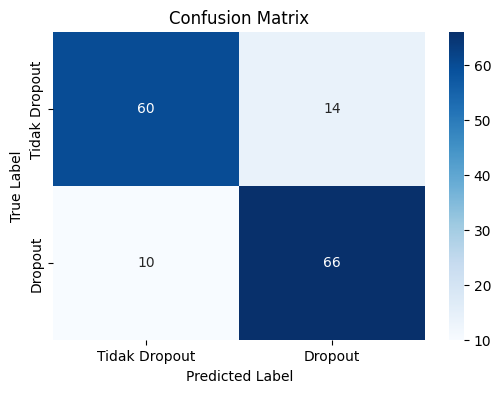


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        74
           1       0.82      0.87      0.85        76

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150


ROC AUC Score: 0.8832


In [18]:
# === MODEL EVALUATION ===

# 1. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualisasikan Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Dropout', 'Dropout'], yticklabels=['Tidak Dropout', 'Dropout'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 3. Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# 4. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

Insight :

Model menunjukkan performa yang baik dengan akurasi 84%, precision dan recall seimbang di kedua kelas, serta skor ROC AUC 0.88 yang mengindikasikan kemampuan klasifikasi yang kuat dan seimbang antara mendeteksi dropout maupun non-dropout.